In [23]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.gating.utilities import centroid, multi_centroid_calculation
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.neighbors import KDTree
from sklearn.cluster import DBSCAN, KMeans
from multiprocessing import Pool, cpu_count
from functools import partial
from itertools import cycle
from datetime import datetime
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
import os
warnings.filterwarnings('ignore')
test_init()

In [3]:
if os.path.isfile('algo_times.csv'):
    performance = pd.read_csv('algo_times.csv').to_dict('list')
else:
    performance = dict(sample_id=[], task=[], method=[], time_seconds=[])

In [4]:
def timed_apply(sample_go, task_name, gate_name, performance_record, plot=True, save=True):
    start = datetime.now()
    sample_go.apply(gate_name, plot_output=plot)
    end = datetime.now()
    performance['sample_id'].append(sample_go.id)
    performance['method'].append(gate_name)
    performance['time_seconds'].append((end-start).total_seconds())
    performance['task'].append(task_name)
    if save:
        pd.DataFrame(performance).to_csv('algo_times.csv', index=False)
    return performance_record

In [5]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [6]:
samples = exp.list_samples()
samples = [x for x in samples if x!= 'sep6']

In [7]:
populations_to_remove = ['gmm_gdt', 'gmm_gdtNEG', 'dbscan_gdt', 'dbscan_nongdt', 'dbscan_vd2',
                        'hdbscan_gdt', 'hdbscan_nongdt', 'hdbscan_vd2', 'dens2d_gdt', 'dens2d_nongdt',
                        'dens2d_vd2', 'dens2d_noise']
gates_to_remove = ['gmm_gdt', 'dbscan_gdt', 'hdbscan_gdt', 'dens2d_gdt']
for x in samples:
    hc = Gating(exp, x)
    for p in populations_to_remove:
        if p in hc.populations.keys():
            hc.populations.pop(p)
    for g in gates_to_remove:
        if g in hc.gates.keys():
            hc.gates.pop(g)
    hc.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!
Saved successfully!


In [ ]:
for x in samples:
    print(f'Gating {x}...')
    hc = Gating(exp, x)
    
    print('mixture model...')
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_gdt', definition='+')
    child_populations.add_population('gmm_gdtNEG', definition='-')
    pre_filter=dict(xmin=0.4, xmax=1.0, ymin=0.4, ymax=1.0)
    gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                      k=2)
    hc.create_gate(gate_name='gmm_gdt', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                   kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_gdt',
                          performance_record=performance, save=True, plot=False)
    
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_nongdt', definition='+')
    child_populations.add_population('gmm_nongdtNEG', definition='-')
    pre_filter=dict(xmin=0, xmax=0.5, ymin=0, ymax=0.4)
    gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                      k=2)
    hc.create_gate(gate_name='gmm_nongdt', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                   kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_nongdt',
                          performance_record=performance, save=True, plot=False)
    
    child_populations = ChildPopulationCollection('geom')
    child_populations.add_population('gmm_vd2Neg', definition='+')
    child_populations.add_population('gmm_vd2NegNEG', definition='-')
    pre_filter=dict(xmin=0.5, xmax=1, ymin=0, ymax=0.4)
    gate_definition = dict(x='PanGD', y='Vd2', target=[0.6, 0.8], conf=0.99, rect_filter=pre_filter,
                      k=2)
    hc.create_gate(gate_name='gmm_vd2Neg', parent='manual_liveCD3', class_='MixtureModel', method='gate',
                   kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='gmm_vd2Neg',
                          performance_record=performance, save=True, plot=False)
    
    print('dbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('dbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('dbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('dbscan_vd2', target=[0.6, 0.2], weight=1)

    sampling_kwargs = dict()
    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, distance_nn=0.02,
                          downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='dbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='dbscan', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dbscan_gdt',
                          performance_record=performance, save=True, plot=False)
    
    print('hdbscan...')
    child_populations = ChildPopulationCollection('cluster')
    child_populations.add_population('hdbscan_gdt', target=[0.6, 0.8], weight=2)
    child_populations.add_population('hdbscan_nongdt', target=[0.2, 0.2], weight=2)
    child_populations.add_population('hdbscan_vd2', target=[0.6, 0.2], weight=1)

    gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, downsample_method='density', frac=0.2)
    hc.create_gate(gate_name='hdbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
                   method='hdbscan', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='hdbscan_gdt',
                              performance_record=performance, save=True, plot=False)
    
    print('2D density threshold...')
    child_populations = ChildPopulationCollection('threshold_2d')
    child_populations.add_population('dens2d_gdt', definition=['++'])
    child_populations.add_population('dens2d_nongdt', definition=['--'])
    child_populations.add_population('dens2d_vd2', definition=['-+'])
    child_populations.add_population('dens2d_noise', definition=['+-'])
    gate_definition = dict(x='PanGD', y='Vd2', kde_bw=0.1, peak_threshold=0.05)
    hc.create_gate(gate_name='dens2d_gdt', parent='manual_liveCD3', class_='DensityThreshold', 
                     method='gate_2d', kwargs=gate_definition, child_populations=child_populations)
    performance = timed_apply(sample_go=hc, task_name='Gamma Delta T cells', gate_name='dens2d_gdt',
                          performance_record=performance, save=True, plot=False)
    hc.save(overwrite=True)
    print('Complete!')
    print('.........................................................')

Creating chunks t:0...
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Clustering t:32.126783...
Meta-clustering t:40.570584...
Error checking t:321.65607...
Population assignment t:321.660727...
Expected 3 populations, identified 2; 2
Populations f['dbscan_nongdt', 'dbscan_vd2'] assigned to the same cluster 0;prioritising dbscan_nongdt based on weighting.


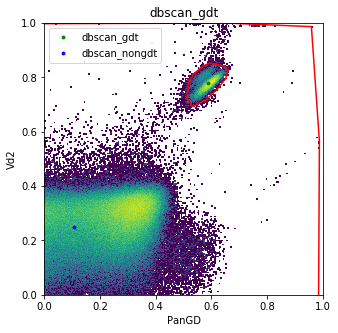

Process ForkPoolWorker-9:
Process ForkPoolWorker-16:
Process ForkPoolWorker-11:
Process ForkPoolWorker-13:
Process ForkPoolWorker-12:
Process ForkPoolWorker-14:
Process ForkPoolWorker-10:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-15:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstr

In [7]:
hc = Gating(exp, 'hc1')
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_gdt', target=[0.6, 0.8], weight=2)
child_populations.add_population('dbscan_nongdt', target=[0.2, 0.2], weight=2)
child_populations.add_population('dbscan_vd2', target=[0.6, 0.2], weight=1)

sampling_kwargs = dict()
gate_definition = dict(x='PanGD', y='Vd2', min_pop_size=100, distance_nn=0.02,
                      downsample_method='density', frac=0.2)
hc.create_gate(gate_name='dbscan_gdt', parent='manual_liveCD3', class_='DensityBasedClustering', 
               method='dbscan', kwargs=gate_definition, child_populations=child_populations)
hc.apply('dbscan_gdt')

In [10]:
def density_dependent_downsample(data, features: list, frac: float = 0.1, sample_n: int or None = None,
                                 alpha: int = 5, mmd_sample_n: int = 2000,
                                 outlier_dens: float = 1, target_dens: float = 5):
    def prob_downsample(local_d, target_d, outlier_d):
        if local_d <= outlier_d:
            return 0
        if outlier_d < local_d <= target_d:
            return 1
        if local_d > target_d:
            return target_d / local_d

    df = data.copy()
    mmd_sample = df.sample(mmd_sample_n)
    tree = KDTree(mmd_sample[features], metric='manhattan')
    dist, _ = tree.query(mmd_sample[features], k=2)
    dist = np.median([x[1] for x in dist])
    dist_threshold = dist * alpha
    ld = tree.query_radius(df[features], r=dist_threshold, count_only=True)
    od = np.percentile(ld, q=outlier_dens)
    td = np.percentile(ld, q=target_dens)
    prob_f = partial(prob_downsample, target_d=td, outlier_d=od)
    prob = list(map(lambda x: prob_f(x), ld))
    if sum(prob) == 0:
        print('Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform '
              'samplings')
        if sample_n is not None:
            return df.sample(n=sample_n)
        return df.sample(frac=frac)
    if sample_n is not None:
        return df.sample(n=sample_n, weights=prob)
    return df.sample(frac=frac, weights=prob)


In [55]:
def _meta_clustering(clustered_chunks: list):
    # Calculate K (number of meta clusters) as the number of expected populations OR the median number of
    # clusters found in each sample IF this median is less that the number of expected populations
    clustered_chunks_woNoise = [x[x['labels'] != -1] for x in clustered_chunks]
    median_k = np.median([len(x['labels'].unique()) for x in clustered_chunks_woNoise])
    k = int(median_k)

    # Calculate centroids of each cluster, this will be used as the training data
    pool = Pool(cpu_count())
    cluster_centroids = pd.concat(pool.map(multi_centroid_calculation, clustered_chunks_woNoise))
    meta = KMeans(n_clusters=k, n_init=10, precompute_distances=True, random_state=42, n_jobs=-1)
    meta.fit(cluster_centroids[['x', 'y']].values)
    cluster_centroids['meta_cluster'] = meta.labels_
    pool.close()
    pool.join()
    return cluster_centroids

In [40]:

    
    return clustered_data, data
    #Plot results
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data['PanGD'], data['Vd2'], bins=500, norm=LogNorm())
    colours = cycle(['green', 'blue', 'red', 'magenta', 'cyan'])
    for label, colour in zip(data['labels'].unique(), colours):
        d = sample[sample['labels'] == label][['PanGD', 'Vd2']].values
        if label == -1:
            ax.scatter(d[:, 0], d[:, 1], c='black', s=10, alpha=0.2)
            continue
        centroid_ = centroid(d)
        ax.scatter(x=centroid_[0], y=centroid_[1], c=colour, s=20, label=label)
        hull = ConvexHull(d)
        for s in hull.simplices:
            ax.plot(d[s, 0], d[s, 1], 'k-', c='red')
        ax.legend()
    ax.set_title(f'Chunk {i}')
    fig.show()

In [47]:
data = test.copy()

In [48]:
# Break data into workable chunks
d = np.ceil(data.shape[0]/30000)
chunksize = int(np.ceil(data.shape[0]/d))
chunks = list()
data = data.copy()
kwargs = dict(sample_n=chunksize, features=['PanGD', 'Vd2'])
sampling_func = partial(density_dependent_downsample, **kwargs)

for x in range(0, int(d)):
    if data.shape[0] <= chunksize:
        data['chunk_idx'] = x
        chunks.append(data)
        break
    sample = sampling_func(data=data)
    sample['chunk_idx'] = x
    data = data[~data.index.isin(sample.index)]
    chunks.append(sample)


Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings


In [74]:
# Cluster each chunk!
clustered_data = list()
for sample in chunks:
    model = DBSCAN(eps=0.03,
                   min_samples=100,
                   algorithm='ball_tree',
                   n_jobs=-1)
    model.fit(sample[['PanGD', 'Vd2']])
    db_labels = model.labels_
    sample['labels'] = db_labels
    clustered_data.append(sample)

In [75]:
meta_clusters = _meta_clustering(clustered_data)

In [76]:
def meta_assignment(df, meta_clusters):
    df = df.copy()
    ref_df = meta_clusters[meta_clusters['chunk_idx'] == df['chunk_idx'].values[0]]
    df['labels'] = df['labels'].apply(lambda x:
                                      -1 if x == -1 else ref_df[ref_df['cluster'] == x]['meta_cluster'].values[0])
    return df

In [77]:
# Perform meta clustering and merge clusters across samples
f = partial(meta_assignment, meta_clusters=meta_clusters)
pool = Pool(cpu_count())
data = pd.concat(pool.map(f, clustered_data))

Process ForkPoolWorker-185:
Process ForkPoolWorker-186:
Process ForkPoolWorker-187:
Process ForkPoolWorker-188:
Process ForkPoolWorker-192:
Process ForkPoolWorker-191:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-189:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-190:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, *

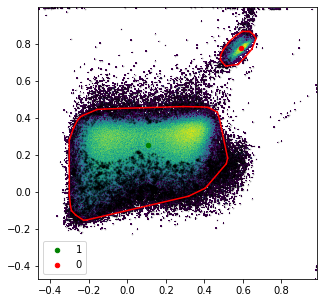

In [82]:
#Plot results
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(data['PanGD'], data['Vd2'], bins=500, norm=LogNorm())
colours = cycle(['green', 'blue', 'red', 'magenta', 'cyan'])
for label, colour in zip(data['labels'].unique(), colours):
    d = data[data['labels'] == label][['PanGD', 'Vd2']].values
    if label == -1:
        ax.scatter(d[:, 0], d[:, 1], c='black', s=1, alpha=0.2)
        continue
    centroid_ = centroid(d)
    ax.scatter(x=centroid_[0], y=centroid_[1], c=colour, s=20, label=label)
    hull = ConvexHull(d)
    for s in hull.simplices:
        ax.plot(d[s, 0], d[s, 1], 'k-', c='red')
    ax.legend()
fig.show()

In [125]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

def is_point_in_poly(row, x, y, poly):
    if poly.contains(Point(row[x], row[y])):
        return True
    return False

def polygon_correction(data, x, y):
    new_data = data.copy()
    # Calculate polygons
    for label in data['labels'].unique():
        if label == -1:
            continue
        d = data[data['labels'] == label][[x, y]].values
        hull = ConvexHull(d)
        poly = Polygon([(d[v, 0], d[v, 1]) for v in hull.vertices])
        mask = data.apply(lambda r: is_point_in_poly(r, x, y, poly), axis=1)
        new_data['labels'] = new_data['labels'].mask(mask, label)
    return new_data

In [126]:
corrected_data = polygon_correction(data, 'PanGD', 'Vd2')

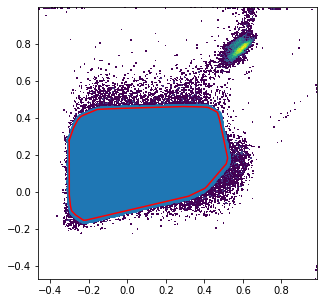

In [124]:
cluster1 = data[data['labels'] == 1][['PanGD', 'Vd2']].values
hull = ConvexHull(cluster1)
cluster1_poly = Polygon([(cluster1[v, 0], cluster1[v, 1]) for v in hull.vertices])
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(corrected_data['PanGD'], corrected_data['Vd2'], bins=500, norm=LogNorm())
x,y = cluster1_poly.exterior.xy
mask = data.apply(lambda r: is_point_in_poly(r, 'PanGD', 'Vd2', cluster1_poly), axis=1)
masked = corrected_data.loc[mask]
ax.scatter(x=masked['PanGD'], y=masked['Vd2'])
ax.plot(x,y,c='r')
fig.show()

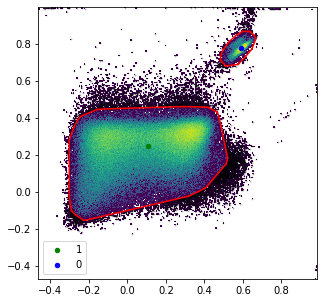

In [127]:
#Plot results
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(corrected_data['PanGD'], corrected_data['Vd2'], bins=500, norm=LogNorm())
colours = cycle(['green', 'blue', 'red', 'magenta', 'cyan'])
for label, colour in zip(corrected_data['labels'].unique(), colours):
    d = corrected_data[corrected_data['labels'] == label][['PanGD', 'Vd2']].values
    if label == -1:
        ax.scatter(d[:, 0], d[:, 1], c='black', s=1, alpha=0.2)
        continue
    centroid_ = centroid(d)
    ax.scatter(x=centroid_[0], y=centroid_[1], c=colour, s=20, label=label)
    hull = ConvexHull(d)
    for s in hull.simplices:
        ax.plot(d[s, 0], d[s, 1], 'k-', c='red')
    ax.legend()
fig.show()

In [41]:
hc = Gating(exp, 'hc1')
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_gdt', target=[0.6, 0.8], weight=2)
child_populations.add_population('dbscan_nongdt', target=[0.2, 0.2], weight=2)
child_populations.add_population('dbscan_vd2', target=[0.6, 0.2], weight=1)

In [42]:
test = apply_transform(hc.get_population_df('manual_liveCD3'), ['PanGD', 'Vd2'], 'logicle')

In [43]:
clustered, meta_clustered = dbscan(test, distance_nn=0.02)

Creating chunks t:0...
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform samplings
Clustering t:32.709945...
Meta-clustering t:41.778323...


Process ForkPoolWorker-120:
Process ForkPoolWorker-115:
Process ForkPoolWorker-119:
Process ForkPoolWorker-114:
Process ForkPoolWorker-118:
Process ForkPoolWorker-116:
Process ForkPoolWorker-117:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-113:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.ru

In [44]:
x = pd.concat(clustered)

In [45]:
x['labels'].unique()

array([ 0, -1,  1,  2,  3,  5,  4])

In [46]:
meta_clustered['labels'].unique()

array([0, 1])